# 1. Descarga y exploración del corpus

**Paso 1: Cargar y Visualizar el Dataset en Google Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

WORKING_PATH = '/content/drive/MyDrive/NLP'

In [1]:
import pandas as pd
import os

# Definir la ruta del archivo
WORKING_PATH = "./"
DATASET_PATH = os.path.join(WORKING_PATH, "Video_Games_5.json")

# Cargar el dataset
df = pd.read_json(DATASET_PATH, lines=True)

# Mostrar las primeras filas del dataset
print("📌 Primeras filas del dataset:")
df.head()


📌 Primeras filas del dataset:


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1,Wrong key,1403913600,"06 28, 2014"
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version,...",3,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011"
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4,DIRT 3,1308009600,"06 14, 2011"


**Paso 2: Cardinalidad del Vocabulario**

In [7]:
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

# Descargar stopwords de NLTK (si no están descargadas)
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Función para tokenizar y limpieza del texto
def clean_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r"[^\w\s]", "", text)  # Eliminar puntuación
    words = text.split()  # Tokenizar dividiendo por espacios
    words = [word for word in words if word not in stop_words]  # Eliminar stopwords
    return words

# Concatenar todas las reseñas en un solo texto
all_reviews = " ".join(df["reviewText"].dropna())

# Tokenizar y contar palabras únicas
words = clean_text(all_reviews)
vocab_size = len(set(words))  # Cardinalidad del vocabulario

# Aplicar la limpieza al texto y guardar en un nuevo DataFrame
df["tokens_clean"] = df["reviewText"].dropna().apply(clean_text)

# Mostrar las primeras filas después del preprocesamiento
print(df[["reviewText", "tokens_clean"]].head())

print(f"\nNúmero de palabras únicas en el vocabulario: {vocab_size}")


[nltk_data] Downloading package stopwords to C:\Users\Alejandro
[nltk_data]     Catalan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                          reviewText  \
0  Installing the game was a struggle (because of...   
1  If you like rally cars get this game you will ...   
2  1st shipment received a book instead of the ga...   
3  I got this version instead of the PS3 version,...   
4  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                        tokens_clean  
0  [installing, game, struggle, games, windows, l...  
1  [like, rally, cars, get, game, funit, oriented...  
2  [1st, shipment, received, book, instead, game2...  
3  [got, version, instead, ps3, version, turned, ...  
4  [dirt, 2, xbox, 360, okay, game, started, play...  

Número de palabras únicas en el vocabulario: 594641


**Paso 3: Distribución de Reviews por Número de Estrellas**

📌 Distribución de reviews por número de estrellas:
overall
1     14853
2     13663
3     28275
4     54804
5    120185
Name: count, dtype: int64


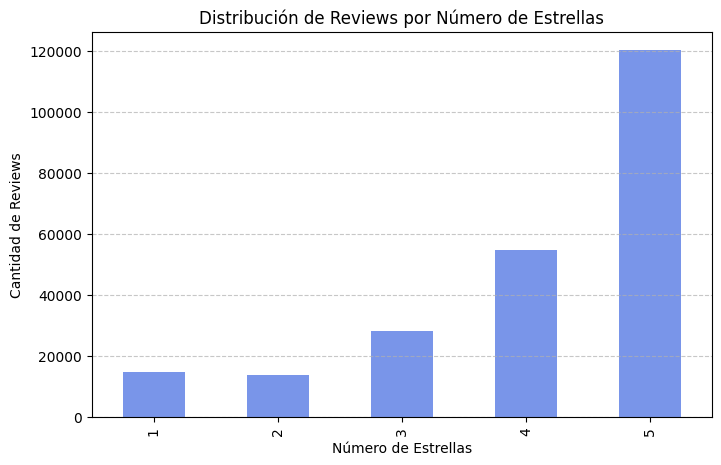

In [8]:
import matplotlib.pyplot as plt

# Contar cuántas reviews hay por cada calificación de estrellas
star_distribution = df["overall"].value_counts().sort_index()

# Mostrar distribución en tabla
print("📌 Distribución de reviews por número de estrellas:")
print(star_distribution)

# Gráfico de barras
plt.figure(figsize=(8,5))
star_distribution.plot(kind="bar", color="royalblue", alpha=0.7)
plt.xlabel("Número de Estrellas")
plt.ylabel("Cantidad de Reviews")
plt.title("Distribución de Reviews por Número de Estrellas")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


**Paso 4: Número de Reviews Positivas y Negativas**

*   Reviews Positivas: 4 o 5 estrellas
*   Reviews Negativas: 1, 2 o 3 estrellas


📌 Número de reviews por sentimiento (ajustado):
sentiment
positive    174989
negative     56791
Name: count, dtype: int64


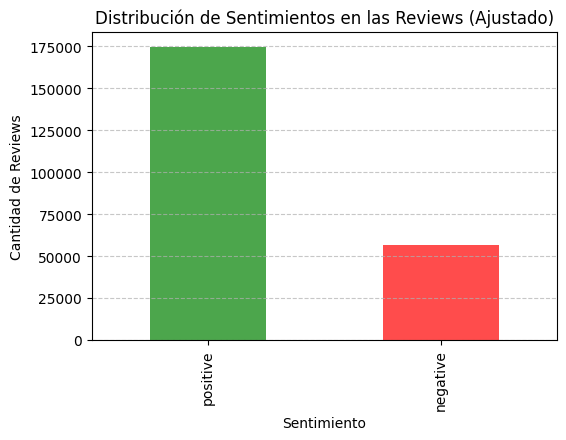

In [9]:
# Reclasificar las reviews: ahora 3 estrellas se consideran negativas
df["sentiment"] = df["overall"].apply(lambda x: "positive" if x >= 4 else "negative")

# Contar cuántas hay de cada tipo
sentiment_counts = df["sentiment"].value_counts()

# Mostrar resultados
print("📌 Número de reviews por sentimiento (ajustado):")
print(sentiment_counts)

# Gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sentiment_counts.plot(kind="bar", color=["green", "red"], alpha=0.7)
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de Reviews")
plt.title("Distribución de Sentimientos en las Reviews (Ajustado)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Paso 5: N-grams Más Frecuentes**

In [12]:
import nltk
from nltk import ngrams
from nltk.probability import FreqDist

# Descargar recursos necesarios de NLTK (solo la primera vez)
"""nltk.download("punkt")"""

# Tokenizar todas las reviews
words_nltk = [word for word in words]

# Función para obtener los N-grams más comunes
def get_top_ngrams_nltk(words, n=2, top_n=10):
    ngrams_list = list(ngrams(words, n))  # Crear bigramas o trigramas
    freq_dist = FreqDist(ngrams_list)  # Calcular frecuencias
    return freq_dist.most_common(top_n)

# Obtener los 10 bigramas y trigramas más frecuentes con NLTK
top_bigrams_nltk = get_top_ngrams_nltk(words_nltk, n=2, top_n=10)
top_trigrams_nltk = get_top_ngrams_nltk(words_nltk, n=3, top_n=10)

# Mostrar resultados
print("📌 Top 10 Bigramas más frecuentes (NLTK):")
for bigram, count in top_bigrams_nltk:
    print(f"{' '.join(bigram)}: {count}")

print("\n📌 Top 10 Trigramas más frecuentes (NLTK):")
for trigram, count in top_trigrams_nltk:
    print(f"{' '.join(trigram)}: {count}")


📌 Top 10 Bigramas más frecuentes (NLTK):
game play: 17263
great game: 15330
play game: 13076
playing game: 10669
single player: 10362
one best: 10105
fun game: 10063
xbox 360: 10014
feel like: 9929
good game: 9894

📌 Top 10 Trigramas más frecuentes (NLTK):
one best games: 2535
grand theft auto: 2374
ive ever played: 2053
metal gear solid: 2045
super mario bros: 1990
first person shooter: 1890
dont get wrong: 1634
single player campaign: 1527
highly recommend game: 1482
game ive played: 1172


**Paso 6: Generar una Nube de Palabras**

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=80, background_color="white").generate(all_reviews)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_word_cloud(words)

ModuleNotFoundError: No module named 'wordcloud'

**Paso 7: Visualización en 2D de Word Embeddings con Word2Vec**

In [ ]:
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Entrenar Word2Vec con los tokens normalizados
word2vec_model = Word2Vec(sentences=df["tokens_clean"], vector_size=100, window=5, min_count=5, workers=4)

# Seleccionar palabras clave manualmente
selected_words = ["game", "graphics", "story", "multiplayer"]

# Obtener palabras más similares para cada una
similar_words = {}
for word in selected_words:
    if word in word2vec_model.wv:
        similar_words[word] = [w for w, _ in word2vec_model.wv.most_similar(word, topn=10)]

# Lista de palabras a visualizar (seleccionadas + similares)
words_to_plot = list(set(selected_words + sum(similar_words.values(), [])))

# Obtener vectores de palabras
word_vectors = np.array([word2vec_model.wv[word] for word in words_to_plot])

# Reducir dimensión con PCA a 2D
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Graficar embeddings
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.5)

# Etiquetar palabras en la gráfica
for i, word in enumerate(words_to_plot):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=10, alpha=0.75)

plt.title("📌 Palabras Clave y sus 10 Más Similares en Word2Vec (Texto Normalizado)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid()
plt.show()

# Mostrar palabras y sus más similares en texto
for word, similar in similar_words.items():
    print(f"\n📌 Palabras más similares a '{word}':")
    print(", ".join(similar))


ModuleNotFoundError: No module named 'gensim'

In [22]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

# Reducir dimensión con t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
word_vectors_2d_tsne = tsne.fit_transform(word_vectors)

# Colorear cada grupo basado en la palabra seleccionada
colors = cm.get_cmap("tab10", len(selected_words))  # Paleta de colores
group_colors = {word: i for i, word in enumerate(selected_words)}  # Asignar colores

# Graficar
plt.figure(figsize=(12, 8))
for i, word in enumerate(words_to_plot):
    group_idx = next((group_colors[w] for w in selected_words if w in similar_words and word in similar_words[w]), None)
    color = colors(group_idx) if group_idx is not None else "gray"
    plt.scatter(word_vectors_2d_tsne[i, 0], word_vectors_2d_tsne[i, 1], color=color, alpha=0.7)
    plt.annotate(word, xy=(word_vectors_2d_tsne[i, 0], word_vectors_2d_tsne[i, 1]), fontsize=10, alpha=0.75)

plt.title("📌 Palabras Clave y sus 10 Más Similares (t-SNE)")
plt.xlabel("Dimensión 1 (t-SNE)")
plt.ylabel("Dimensión 2 (t-SNE)")
plt.grid()
plt.show()

NameError: name 'word_vectors' is not defined

**Paso 8: Conclusiones del Análisis Exploratorio**

🔹 Conclusiones del Análisis Exploratorio

✔️ Cardinalidad del Vocabulario:

El dataset tiene 594,788 palabras únicas, indicando un vocabulario amplio y variado.

✔️ Distribución de Reviews por Estrellas:

Más del 50% de las reviews tienen 5 estrellas, lo que muestra una tendencia hacia evaluaciones positivas.
Las reviews con 1 o 2 estrellas son minoría, lo que sugiere menos insatisfacción general.

✔️ Clasificación de Sentimientos:

174,989 reviews (75.5%) son positivas (4 o 5 estrellas).
56,791 reviews (24.5%) son negativas (1, 2 o 3 estrellas).

✔️ N-grams Más Frecuentes:

Se identificaron expresiones clave en las opiniones, como "great game", "fun game", "single player campaign", lo que muestra qué aspectos valoran más los usuarios.

✔️ Nube de Palabras:

Los términos más usados reflejan aspectos clave del gaming, como "game", "play", "fun", "graphics", "story", indicando que los usuarios destacan experiencias de juego.

✔️ Visualización de Word Embeddings:

Se observó una clara agrupación de palabras con significados similares, confirmando que el modelo Word2Vec está capturando relaciones semánticas entre términos.